In [1]:
# Importing necessary libraries
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Importing custom modules
from engine_DP import CoinGame
from agent_DP import RandomAgent, IndQLearningAgentSoftmax, Level2QAgentSoftmax, Level2QAgent_fixed
# from agent_DP import ExpSmoother, FPLearningAgent, Level2QAgent, RandomAgent, IndQLearningAgent, Level3QAgent, Level3QAgentMixExp, Level3QAgentMixDir

In [2]:
def moving_average(a, n=3):
    """
    Compute the simple moving average of a 1D array.

    Parameters:
        a (array-like): Input array containing numerical data.
        n (int, optional): Window size for the moving average. Defaults to 3.

    Returns:
        ndarray: Array of moving averages with length len(a) - n + 1.
    """
    # Compute cumulative sum of the input array as float
    ret = np.cumsum(a, dtype=float)
    
    # Subtract the cumulative sum shifted by 'n' to get the sum over each window
    ret[n:] = ret[n:] - ret[:-n]
    
    # Divide by window size to obtain the moving average
    return ret[n - 1:] / n

def plot(r0ss, r1ss, moving_average_window_size=1000, dir=None):
    """
    Plot smoothed reward trajectories for two agents over multiple experiments.

    Parameters:
        r0ss (list of arrays): Rewards for Agent A across experiments.
        r1ss (list of arrays): Rewards for Agent B across experiments.
        dir (str, optional): If provided, saves the plot to 'dir.png'.

    Returns:
        None
    """
    # Apply 'ggplot' style for aesthetics
    plt.style.use('ggplot')

    N_EXP = len(r0ss)  # Number of experiments

    # Plot individual experiment trajectories with low opacity
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], moving_average_window_size), 'b', alpha=0.05)
        plt.plot(moving_average(r1ss[i], moving_average_window_size), 'r', alpha=0.05)

    # Plot average trajectory across experiments with higher opacity
    plt.plot(moving_average(np.mean(r0ss, axis=0), moving_average_window_size), 'b', alpha=0.5)
    plt.plot(moving_average(np.mean(r1ss, axis=0), moving_average_window_size), 'r', alpha=0.5)

    # Label axes
    plt.xlabel('t')
    plt.ylabel('R')

    # Create custom legend
    custom_lines = [Line2D([0], [0], color='b', label='Agent A'),
                    Line2D([0], [0], color='r', label='Agent B')]
    plt.legend(handles=custom_lines)

    # Save plot if directory is specified
    if dir is not None:
        plt.savefig(f"{dir}.png")

## Experiment setup

In [3]:
## Setup experiment 1

# Number of experiments
N_EXP = 5

# Size of single dimension of the square grid
grid_size = 11

# Number of states 
n_states = (grid_size*grid_size)**4

# Number of episodes 
n_iter = 100

# Constant gamma 
gamma = 0.95

# Learning rate
learning_rate = 0.5

# Epsilon for epsilon greedy policy
epsilon = 0.1

# Initialize environment 
env = CoinGame(max_steps=10000000000000, size_square_grid=grid_size)

# Moving average window size for plotting 
moving_average_window_size = 5

r0ss = []
r1ss = []

0
1
2
3
4


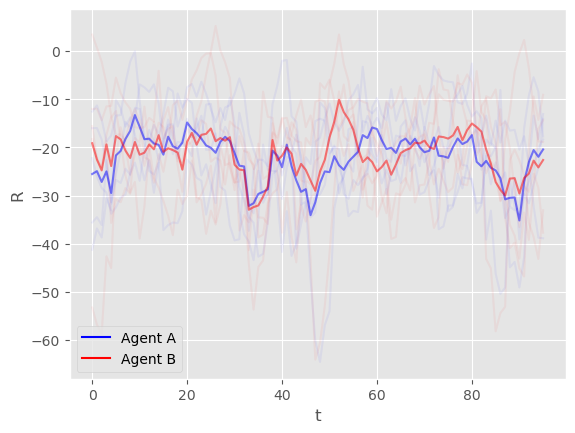

In [4]:
# Run the experiments
for n in range(N_EXP):
    
    ## Initialize agents
    # TODO: Add reset method to individual agents and move them to initialization
    #* Note: The agent's here are reinitialized, instead reset can be done by reseting the Q matrix inside the agent.

    P2 = IndQLearningAgentSoftmax(env.available_actions_Adv, n_states, learning_rate=learning_rate,
                           epsilon=epsilon, gamma=gamma, enemy_action_space=None)
    P1 = IndQLearningAgentSoftmax(env.available_actions_DM, n_states, learning_rate=learning_rate,
                           epsilon=epsilon, gamma=gamma, enemy_action_space=None)

    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    # P2 = RandomAgent( env.available_actions, p=0.5)
    # P1 = Level2QAgentSoftmax(env.available_actions_DM, env.available_actions_Adv, n_states=n_states,
    #                   learning_rate=.9, epsilon=0.1, gamma=gamma)

    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Run through episodes
    for i in range(n_iter):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        
        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(s)
            a2 = P2.act(s)

            # Transition to next time step
            s_new, rewards, done =  env.step([a1,a2])

            # Agents update their Q/Value functions
            # * Note: They update their Q/Value functions simultaneously
            P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)
            P2.update(s, [a2, a1], [rewards[1], rewards[0]], s_new)
            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        env.reset()
        if i%10 == 0:
            P1.epsilon *= 0.995
            P2.epsilon *= 0.995
    
          
        
    print(n)
    r0ss.append(r0s)
    r1ss.append(r1s)
    
plot(r0ss, r1ss, moving_average_window_size=moving_average_window_size, dir=None)

0
1
2
3
4
0.1
0.1


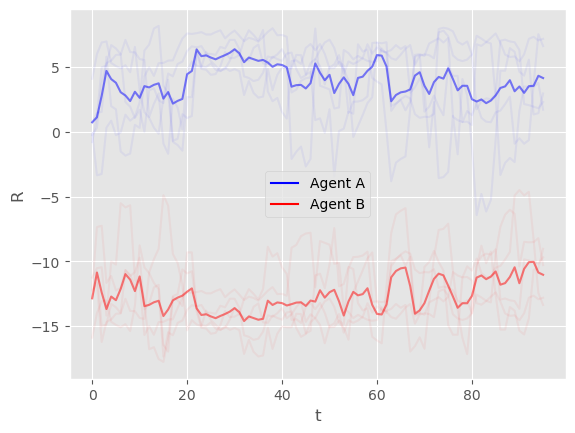

In [ ]:
r0ss = []
r1ss = []


# Run the experiments
for n in range(N_EXP):
    
    ## Initialize agents
    # TODO: Add reset method to individual agents and move them to initialization
    #* Note: The agent's here are reinitialized, instead reset can be done by reseting the Q matrix inside the agent.

    P2 = IndQLearningAgentSoftmax(env.available_actions_Adv, n_states, learning_rate=learning_rate,
                           epsilon=epsilon, gamma=gamma, enemy_action_space=None)
    # P1 = IndQLearningAgentSoftmax(env.available_actions_DM, n_states, learning_rate=.5,
    #                       epsilon=0.1, gamma=gamma, enemy_action_space=None)

    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    # P2 = RandomAgent( env.available_actions, p=0.5)
    # P1 = Level2QAgentSoftmax(env.available_actions_DM, env.available_actions_Adv, n_states=n_states,
    #                       learning_rate=learning_rate, epsilon=epsilon, gamma=gamma)
    
    P1 = Level2QAgent_fixed(env.available_actions_DM, env.available_actions_Adv, n_states=n_states,
                            learning_rate=learning_rate, epsilon=epsilon, gamma=gamma)

    
    # Reset the reward vectors for the experiment
    r0s = []
    r1s = []
    
    # Run through episodes
    for i in range(n_iter):

        # Initialize the end of episode flag
        done = False
        # Reset the environment after each episode
        env.reset()
        # Get the initial state
        s = env.get_state()
        
        # Initialize cummulative observed rewards for this episode
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
        
        # While the agents have not reached the terminal state
        while not done:
            # Agents choose actions 
            # * Note: They choose the actions simultaneously
            a1 = P1.act(s)
            a2 = P2.act(s)

            # Transition to next time step
            s_new, rewards, done =  env.step([a1,a2])

            # Agents update their Q/Value functions
            # * Note: They update their Q/Value functions simultaneously
            P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)
            P2.update(s, [a2, a1], [rewards[1], rewards[0]], s_new)
            
            # Set the current state to the new state
            s = s_new  
            
            # Add the observed reward to the episode reward of both agents 
            # * Note: The rewards are observed simultaneously
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
            
        # Append the episode rewards to the list of rewards for this experiment
        r0s.append(episode_rewards_DM)
        # Append the episode rewards to the list of rewards for this experiment
        r1s.append(episode_rewards_Adv)
        
        # if i%10 == 0:
        #     P1.epsilonA *= 0.995
        #     P2.epsilon *= 0.995
        #     #P1.epsilonB *= 0.9
    
    env.reset() # Reset the environment at the very end
    
    print(n)
    r0ss.append(r0s)
    r1ss.append(r1s)

print(P1.epsilonA)
print(P2.epsilon)
    
plot(r0ss, r1ss, moving_average_window_size=moving_average_window_size)